In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv("yelp_reviews_subset_2.csv") # Replace None with the correct code
df

,Unnamed: 0,Text,Labels
0,0,My expectations for McDonalds are t rarely hig...,0
1,1,I've tried to give this McDonalds a chance but...,0
2,2,This McDonald's is so bad it's amazing. \n\nO...,0
3,3,We had the worst possible experience at the Ea...,0
4,4,They burned my fish and they burned it bad. O...,2
...,...,...,...
495,495,This place is PHENOMENAL.\nI got my bunny here...,4
496,496,"This is a bizarre CVS, the kind you would only...",1
497,497,"I go to this CVS all the time, since I work in...",1
498,498,"Never again. Let me repeat, never again. \n\nT...",0


C:\Users\kusha\AppData\Local\Temp\ipykernel_14940\586133965.py:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


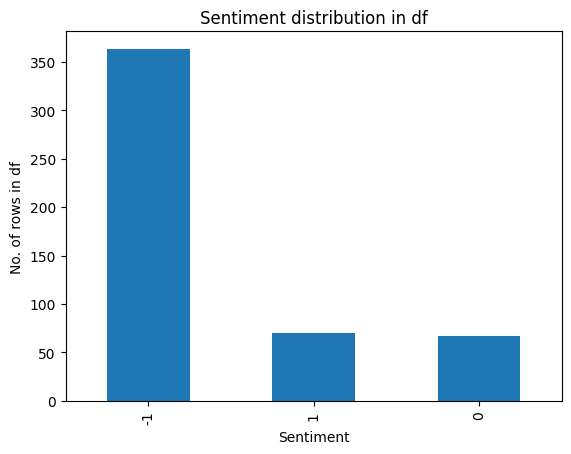

In [2]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1


# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['Labels']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [ ]:
# Tokenize each sentence into word tokens and store them as a list in the dataframe
# Use List Comprehension
df['tokenized_text'] = [word_tokenize(review) for review in df['Text']]  # Replace None with the correct code
print(df['tokenized_text'].head(10))

ps = PorterStemmer()
# Use the Porter Stemmer to find stem words of each word for all the words in df["tokenized_text"]
# Hint: Use List Comprehension
df['stemmed_tokens'] = [[ps.stem(word) for word in tokens] for tokens in df['tokenized_text']] # Replace None with the correct code
df['stemmed_tokens'].head(10)

0    [My, expectations, for, McDonalds, are, t, rar...
1    [I, 've, tried, to, give, this, McDonalds, a, ...
2    [This, McDonald, 's, is, so, bad, it, 's, amaz...
3    [We, had, the, worst, possible, experience, at...
4    [They, burned, my, fish, and, they, burned, it...
5    [Some, how, even, though, the, food, at, this,...
6    [Mmm, ..., peppermint, mocha\n\nIn, my, quest,...
7    [If, there, was, ever, a, \, '', get, your, co...
8    [I, just, realized, they, remodeled, this, one...
9    [Great, location, !, Close, to, shops, and, th...
Name: tokenized_text, dtype: object


0    [my, expect, for, mcdonald, are, t, rare, high...
1    [i, 've, tri, to, give, thi, mcdonald, a, chan...
2    [thi, mcdonald, 's, is, so, bad, it, 's, amaz,...
3    [we, had, the, worst, possibl, experi, at, the...
4    [they, burn, my, fish, and, they, burn, it, ba...
5    [some, how, even, though, the, food, at, thi, ...
6    [mmm, ..., peppermint, mocha\n\nin, my, quest,...
7    [if, there, wa, ever, a, \, '', get, your, cof...
8    [i, just, realiz, they, remodel, thi, one, rec...
9    [great, locat, !, close, to, shop, and, theatr...
Name: stemmed_tokens, dtype: object

In [ ]:
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[["Text", "Labels", "tokenized_text", "stemmed_tokens"]],
                                                        df['sentiment'],
                                                        shuffle=shuffle_state,
                                                        test_size=test_size,
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Replace None with the correct code
print("Device available for running: ")
print(device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()

        # Linear function 1: input_dim --> hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: hidden_dim --> hidden_dim
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3 (readout): hidden_dim --> output_dim
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Forward pass through fully connected layer 1
        out = self.fc1(x)
        out = self.relu1(out)

        # Forward pass through fully connected layer 2
        out = self.fc2(out)
        out = self.relu2(out)

        # Forward pass through fully connected layer 3
        out = self.fc3(out)

        # Apply softmax along the output dimension
        return F.softmax(out, dim=1)


In [ ]:
# Function to return the dictionary either with padding word or without padding
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(df, padding=False)

In [ ]:
VOCAB_SIZE = 30056
NUM_LABELS = 3

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [ ]:
VOCAB_SIZE = len(review_dict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

# Call the FeedForwardNeuralNetwork Class object with appropriate arguements
ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim) # Replace None with the correct code

# Move the model to device
ff_nn_bow_model = ff_nn_bow_model.to(device) # Replace None with the correct code

# Define the loss function as Cross Entropy Loss
loss_function = nn.CrossEntropyLoss() # Replace None with the correct code

# Define a Stochastic Gradient Descent Optimizer with learning rate of 1e-3
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=1e-3) # Replace None with the correct code

In [ ]:
# Open the file for writing loss
ffnn_loss_file_name = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # Make the bag of words vector for stemmed tokens
        bow_vec = torch.tensor(make_bow_vector(row['tokens'], review_dict), dtype=torch.float).unsqueeze(0).to(device) # Replace None with the correct code

        # Forward pass to get output
        probs = ff_nn_bow_model(bow_vec) # Replace None with the correct code

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target) # Replace None with the correct code

        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()

In [ ]:
bow_ff_nn_predictions = []
original_lables_ff_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_500_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_500_padding_100_epochs.get_figure()
fig.savefig("ffnn_bow_loss_500_padding_100_epochs_less_lr.jpg")


In [ ]:
# Initialize the Feedforward Neural Network model with dropout
# Create a model instance with the given input, hidden, and output dimensions
dropout_rate = 0.3  # Example dropout rate
ff_nn_bow_model_dropout = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, dropout_rate=dropout_rate)  # Replace None with model initialization (include dropout_rate parameter)
ff_nn_bow_model_dropout.to(device)

# Define loss function and optimizer
loss_function_dropout = nn.CrossEntropyLoss()  # Replace None with appropriate loss function
optimizer_dropout = optim.SGD(ff_nn_bow_model.parameters(), lr=1e-3)   # Replace None with optimizer

# Prepare to record training loss
ffnn_loss_file_name_dropout = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr_dropout.csv'
f_dropout = open(ffnn_loss_file_name_dropout, 'w')
f_dropout.write('iter, loss\n')
losses_dropout = []
iter_dropout = 0

# Train the model
ff_nn_bow_model_dropout.train()
for epoch in range(num_epochs):
    if (epoch + 1) % 25 == 0:
        print(f"Epoch completed: {epoch + 1}")

    train_loss_dropout = 0

    # Iterate through training samples
    for index, row in X_train.iterrows():
        optimizer_dropout.zero_grad()

        # Create bag-of-words input vector and target
        bow_vec = torch.tensor(make_bow_vector(row['tokens'], review_dict), dtype=torch.float).unsqueeze(0).to(device)  # Replace None with code to create BoW vector from review_dict and tokens (call previous functions defined)
        probs = ff_nn_bow_model_dropout(bow_vec)  # Replace None with forward pass through the model
        target = make_target(Y_train['sentiment'][index]).to(device)  # Replace None with code to create target tensor

        # TODO: Compute loss
        loss = loss_function_dropout(probs,target)  # Replace None with loss computation
        train_loss_dropout += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer_dropout.step()

    # Log average loss for the epoch
    f_dropout.write(f"{epoch + 1},{train_loss_dropout / len(X_train)}\n")
    train_loss_dropout = 0

f_dropout.close()


In [ ]:
bow_ff_nn_predictions_dropout = []
original_lables_ff_bow_dropout = []

ff_nn_bow_model_dropout.eval() # Set model to evaluation mode
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        bow_ff_nn_predictions_dropout.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow_dropout.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print("Classification Report with Dropout:")
print(classification_report(original_lables_ff_bow_dropout, bow_ff_nn_predictions_dropout))

ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
ffnn_loss_df_dropout = pd.read_csv(ffnn_loss_file_name_dropout)

plt.figure(figsize=(10, 6))
plt.plot(ffnn_loss_df['iter'], ffnn_loss_df[' loss'], label='Without Dropout')
plt.plot(ffnn_loss_df_dropout['iter'], ffnn_loss_df_dropout[' loss'], label='With Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with and Without Dropout')
plt.legend()
plt.grid(True)
plt.savefig("ffnn_bow_loss_comparison_dropout.jpg")
plt.show()